Razafimbelo Fanoa & Nguyen Thi Thuy Trang

# Projet phylogénétique
Théophile Sanchez (theophile.sanchez@inria.fr) - Sarah Cohen Boulakia

------

## Introduction

Au cours de ce projet, vous étudierez trois espèces disparues de félins qui vivaient autrefois sur le continent Américain. Ces trois espèces, le _smilodon_ (tigre à dents de sabre), l'*homotherium* (*scimitar toothed tigers*) et *Miracinonyx trumani* (guépard américain) se sont éteintes il y a environ 13 000 ans, à la fin de la dernière période glaciaire. Des séquences ADN anciennes de la protéine cytochrome b de ces espèces ont pu être séquencées et vont vous permettre de retrouver les liens de parentés entre ces espèces et des espèces de félins contemporaines : le chat domestique, le lion, le léopard, le tigre, le puma, le guépard et les chats sauvages africains, chinois et européens. Sont aussi présentes dans le jeu de donnée des séquences issues d'espèces extérieures aux félins.

Afin de reconstruire l'arbre phylogénétique de ces espèces, vous utiliserez une méthode basée sur le calcul des distances évolutives entre les séquences ADN des protéines. Notez qu'une démarche similaire peut-être appliquée aux séquences d'acides aminés.

Les différentes étapes qui vous permetterons de construire l'arbre sont détaillées dans ce notebook. Vous devrez implémenter les algorithmes en Python et répondre aux questions dans les cellules prévues.

Quelques conseils :
- Utiliser au maximum les fonctions présentes dans les packages de python (sauf si il vous est explicitement demandé de les réimplémenter). Si un problème vous paraît courant, il existe surement déjà une fonction pour le résoudre. Pour ce projet vous serez limité aux packages de base, à Numpy et ETE (seulement pour l'affichage des arbres).
- Si une partie de votre code ne vous semble pas très explicite, ajoutez des commentaires pour l'expliquer. Une personne qui lit votre code doit pouvoir comprendre son fonctionnement facilement.
- N'hésitez pas à chercher dans la documentation et sur internet. Cependant, faites très attention au plagiat, d'après les règles de l'université vous risquez beaucoup s'il est avéré ! 

Le projet est à rendre **en binôme** par mail. Vous regrouperez votre notebook et les fichiers nécessaires à son fonctionnement dans une archive portant vos noms et prénoms.

------
## Importation des séquences

Le format FASTA permet de stocker plusieurs séquences (ADN, ARN ou peptidiques) dans un fichier. Les séquences que vous allez étudier ont été regroupées dans le fichier `cat_dna.fasta`.

**Exercice 1 :** Écriver une fonction permettant d'importer un fichier au format fasta et de le stocker dans un dictionnaire. Les clés seront les noms des séquences et les valeurs du dictionnaire seront les séquences d'adn.

In [1]:
# À remplir
file = open("msa_cat_dna.fasta", "r")
print(file.read())

>Sabertooth DNA (Smilodon)
CTAATTAAAATTATCAACCACTCATTCATTGATTTACCCACCCCATCCAACATTTCAGCA
TGATGAAACTTCGGCTCCTTATTAGGAGTGTGCTTAATCTTACAAATCCTCACTGGCTTA
TTTCTAGCCATACATTATACACCAGATACAACAACCGCCTTCTCATCAGTTACCCACATT
TGCCGTGATGA--ATTACGGCTGAATTATCCGAT--ATATACGCCAATGGAGCTTCCATA
TTCTTCATCTGCCTATATATACATGTAGGTCGAGCATATACTAC

>Homotherium DNA
CTAATTAAAATCATCAACCAATCATTCATTGACTTACCTACCCCCTCCAACATCTCAGCA
TGATGAAACTTCGGATCCCTACTAGGCATTTGCCTAATTCTTCAAATCCTCACAGGCTTA
TTCCTAGCCATACACTACACATCAGACACAACAACTGC-TTCTCATCAATCGCCCATATT
TGCCGTGACGTAAATTATGGTTGAATTATCCGATATATACACGCCAATGGAGCCTCTATA
TTCTTCCTGTCTATACCT--ACATGTAGCTCGAGAATTTATTAC

>American Cat DNA (Miracinonyx)
CTTATTAAAATCATTAATCACTCATTCATTGATCTACCCACCCCATCCAACATTTCAGCA
TGATGAAACTTCGGTTCCCTA-TAGGGGTCTGCCTAATCCTACAAATCCTAACCGGCCTC
TTCCTGGCTATA--CAACACATCAGACACAATAACCGCCTTTTCATCAGTTACTCACATC
TGTCGTGACGTCAATTACGGCTGAATTATTCGGTAT-TACACGCCAACGGAGCCTCCATA
TTCTTTATCTGCCTATACATGCACGTAGGGCGAGAATATATTAC

>Spotted Hyena DNA
CTCATTAAAATTATCAACAAATCATTCATTGACCT

In [2]:
import pprint

In [3]:
def dictionnaire(f):
    with open(f) as file:
        contents = file.read()
        entries = contents.split('>')
        entries.pop(0)
        res = {}
        for entry in entries:
            ADN = ''
            split = entry.split("\n")
            for i in range(1,len(split)):
                key = split[0]
                ADN = ADN + split[i]
            res[key] = ADN
        return res

In [4]:
data = dictionnaire("msa_cat_dna.fasta")

------
## Alignement des séquences

La méthode que vous utiliserez pour calculer l'arbre phylogénétique nécessite de calculer la distance évolutive entre les séquences. Avant de pouvoir les calculer, il faut d'abord aligner les séquences en considérant trois types de mutations :
- les substitutions (un nucléotide est remplacé par un autre)
- les insertions
- les délétions
Par exemple, les séquences "ACTCCTGA" et "ATCTCGTGA" ont plusieurs alignements possibles : 

$A_1$ :
```
-ACTCCTGA
ATCTCGTGA
```

$A_2$ :
```
A-CTCCTGA
ATCTCGTGA
```

$A_3$ :
```
AC-TCCTGA
ATCTCGTGA
```
.

.

.

Il est aussi possible qu'une délétion ne soit pas une mutation, mais en réalité dû à un mauvais séquençage ou à la dégradation ADN comme c'est souvent le cas pour le séquençage d'ADN d'espèces disparues. 

Le "-" désigne un *gap*, c'est à dire un "trou" dans l'alignement qui a été causé par une insertion ou une déletion. On regroupe ces deux types de mutations sous le terme indel.

Ces alignements correspondent à une multitude d'histoires phylogénétiques différentes. Pour sélectionner le meilleur alignement il faut donc introduire l'hypothèse du maximum de parcimonie qui privilégie l'histoire phylogénétique qui implique le moins d'hypothèses et donc, le moins de changements évolutifs. Par exemple, parmis les trois alignements ci-dessus on preferera l'alignement 2 car il correspond au scénario avec le moins de mutations:
- l'alignement 1 implique au minimum 1 indel et 2 substitutions
- l'alignement 2 implique au minimum 1 indel et 1 substitutions
- l'alignement 3 implique au minimum 1 indel et 2 substitutions

On peut maintenant définir un score d'identité que l'on va augmenter de 1 lorsque qu'il n'y pas eu de mutation et ainsi obtenir la matrice suivante :

|   &nbsp;   | A | C | G | T | - |
|   -   | - | - | - | - | - |
| **A** | 1 | 0 | 0 | 0 | 0 |
| **C** | 0 | 1 | 0 | 0 | 0 |
| **G** | 0 | 0 | 1 | 0 | 0 |
| **T** | 0 | 0 | 0 | 1 | 0 |
| **-** | 0 | 0 | 0 | 0 | 0 |

Cette matrice correspond au modèle d'évolution de l'ADN défini par Jukes et Cantor qui fait l'hypothèse d'un taux de mutation équivalent pour chacun des nucléotides. Cependant, en réalité ces taux ne sont pas les mêmes partout, on sait par exemple que le taux de transition (substitution A$\leftrightarrow$G ou C$\leftrightarrow$T) est différent du taux de transversions (substitution A$\leftrightarrow$T, C$\leftrightarrow$G, C$\leftrightarrow$A ou G$\leftrightarrow$T) et que d'autres facteurs devrait être pris en compte comme la fréquence du nucléotide dans l'ADN. [C'est pour cette raison qu'il existe beaucoup de modèles différents d'écrivant l'évolution de l'ADN.](https://en.wikipedia.org/wiki/Models_of_DNA_evolution) Dans la suite de ce projet nous utiliserons la matrice de similarité $S$ suivante : 

|   &nbsp;   | A  | C  | G  | T  | -  |
|   -   | -  | -  | -  | -  | -  |
| **A** | 10 | -1 | -3 | -4 | -5 |
| **C** | -1 | 7  | -5 | -3 | -5 |
| **G** | -3 | -5 | 9  | 0  | -5 |
| **T** | -4 | -3 | 0  | 8  | -5 |
| **-** | -5 | -5 | -5 | -5 | 0  |

**Exercice 2 :** Écriver la fonction permettant de calculer le score entre deux séquences avec la matrice de similarité précédente puis afficher le score des trois alignements $A_1$, $A_2$ et $A_3$. La classe permettant d'importer une matrice et de calculer le score entre deux lettres vous est déjà fournie, la matrice de similarité est stockée dans le fichier `dna_matrix` :


In [5]:
import numpy as np


class SimilarityMatrix:
    def __init__(self, filename):
        with open(filename) as f:
            self.letters = f.readline().split()
            self.values = np.loadtxt(filename, skiprows=1, usecols=range(1, len(self.letters) + 1))
        
    def score(self, letter1, letter2): # return the similarity score between letter1 and letter2
        return self.values[self.letters.index(letter1)][self.letters.index(letter2)]
    
# Example
similarity_matrix = SimilarityMatrix('dna_matrix')
print('Score between G and C:', similarity_matrix.score('G', 'C'))
print('Score between A and a gap:', similarity_matrix.score('-', 'A'))

Score between G and C: -5.0
Score between A and a gap: -5.0


In [6]:
# À remplir
def alignement(a,b):
    score = [0,0,0]
    for j in range(3):
        s = a
        s = s[:j] + "-" + s[j:]
        print(len(s))
        for i in range(len(s)):
            score[j] = score[j] + similarity_matrix.score(s[i], b[i])
    return score

In [7]:
alignement("ACTCCTGA","ATCTCGTGA")

9
9
9


[35.0, 49.0, 39.0]

------
### Algorithme de Needleman-Wunsch

Maintenant que vous avez vu ce qu'est une matrice de similarité et comment calculer le score de similarité d'un alignement, vous allez devoir implémenter un algorithme permettant de trouver le meilleur alignement global entre deux séquences. Avec deux séquences à aligner de taille $n$ et $m$, la première étape consiste à initialiser deux matrices de taille $(n+1) \times (m+1)$. La première est la matrice de score $M$ et la seconde sera la matrice de *traceback* $T$. 

Par exemple, avec la matrice $S$ et les séquences $A =$ "ACTCCTGA" et $B =$ "ATCTCGTGA", on initialise $M$ comme si l'on ajoutait des *gaps* partout :

|   &nbsp;   | - | A | T | C | T | C | G | T | G | A |
|   -   | - | - | - | - | - | - | - | - | - | - |
| **-** | 0 |-5 |-10|-15|-20|-25|-30|-35|-40|-45|
| **A** |-5 | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; |
| **C** |-10| &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; |
| **T** |-15| &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; |
| **C** |-20| &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; |
| **C** |-25| &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; |
| **T** |-30| &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; |
| **G** |-45| &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; |
| **A** |-40| &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; ||

Puis on initialise $T$ :

|   &nbsp;   | - | A | T | C | T | C | G | T | G | A |
|   -   | - | - | - | - | - | - | - | - | - | - |
| **-** | o | l | l | l | l | l | l | l | l | l |
| **A** | u | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; |
| **C** | u | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; |
| **T** | u | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; |
| **C** | u | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; |
| **C** | u | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; |
| **T** | u | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; |
| **G** | u | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; |
| **A** | u | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; ||


Il faut ensuite remplir la matrice $M$ en suivant la formule $M_{ij} = \max(M_{i-1j-1} + s(A_i, B_j), M_{ij-1} + s(A_i, gap), M_{i-1j} + s(B_j,gap) )$ avec $i \in {2, \dots, n+1}$, $j \in {2, \dots, m+1}$ et la fonction $s$ qui calcule le score de similarité entre deux nucléotides. Pour chaque case de $T$ on remplie par :
- 'd' (*diagonal*) si $M_{ij}$ a été calculé en utilisant la diagonale $M_{i-1j-1}$,
- 'l' (*left*) si $M_{ij}$ a été calculé en utilisant la case de gauche $M_{ij-1}$,
- 'u' (*up*) si $M_{ij}$ a été calculé en utilisant la case du haut $M_{i-1j}$.

On obtient alors les matrices suivantes $M$ et $T$ : 

|   &nbsp;   | - | A | T | C | T | C | G | T | G | A |
|   -   | - | - | - | - | - | - | - | - | - | - |
| **-** |  0| -5|-10|-15|-20|-25|-30|-35|-40|-45|
| **A** | -5| 10|  5|  0| -5|-10|-15|-20|-25|-30|
| **C** |-10|  5|  7| 12|  7|  2| -3| -8|-13|-18|
| **T** |-15|  0| 13|  8| 20| 15| 10|  5|  0| -5|
| **C** |-20| -5|  8| 20| 15| 27| 22| 17| 12|  7|
| **C** |-25|-10|  3| 15| 17| 22| 22| 19| 14| 11|
| **T** |-30|-15| -2| 10| 23| 18| 22| 30| 25| 20|
| **G** |-35|-20| -7|  5| 18| 18| 27| 25| 39| 34|
| **A** |-40|-25|-12|  0| 13| 17| 22| 23| 34| 49|

|   &nbsp;   | - | A | T | C | T | C | G | T | G | A |
|   -   | - | - | - | - | - | - | - | - | - | - |
| **-** | o | l | l | l | l | l | l | l | l | l |
| **A** | u | d | l | l | l | l | l | l | l | d |
| **C** | u | u | d | d | l | d | l | l | l | l |
| **T** | u | u | d | l | d | l | l | d | l | l |
| **C** | u | u | u | d | l | d | l | l | l | l |
| **C** | u | u | u | d | d | d | d | d | l | d |
| **T** | u | u | d | u | d | l | d | d | l | l |
| **G** | u | u | u | u | u | d | d | u | d | l |
| **A** | u | d | u | u | u | d | u | d | u | d |

Il suffit maintenant de regarder le dernier élément $M_{nm} = 49$ pour avoir le score de l'alignement. Pour avoir l'alignement lui-même, il faut partir de $T_{nm}$ et remonter la "trace" jusqu'à arriver au 'o'. Un 'd' correspond à un *match* entre les deux séquences, 'l' à un *gap* dans la séquence $A$ et 'u' à un *gap* dans la séquence $B$. En revenant à l'exemple précédent on obtient la trace suivante :

|   &nbsp;   | - | A | T | C | T | C | G | T | G | A |
|   -   | - | - | - | - | - | - | - | - | - | - |
| **-** | o | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; |
| **A** | &nbsp; | d | l | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; |
| **C** | &nbsp; | &nbsp; | &nbsp; | d | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; |
| **T** | &nbsp; | &nbsp; | &nbsp; | &nbsp; | d | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; |
| **C** | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | d | &nbsp; | &nbsp; | &nbsp; | &nbsp; |
| **C** | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | d | &nbsp; | &nbsp; | &nbsp; |
| **T** | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | d | &nbsp; | &nbsp; |
| **G** | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | d | &nbsp; |
| **A** | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | d |

Elle correspond à l'alignement :
```
A-CTCCTGA
ATCTCGTGA
```

**Exercice 3 :** Implémenter l'algorithme de Needlman et Wunsch. Il prendra en paramètre deux séquences et une matrice de similarité et retournera leur alignement. Tester le avec les séquences "ACTCCTGA" et "ATCTCGTGA".

In [8]:
# À remplir
def initMT(a,b,s):
    
    M = np.zeros((len(a),len(b)))
    T = np.full((len(a),len(b)), '')
    T[0,0] = 'o'
    M[0,0] = 0
    for i in range(1,len(a)):
        M[i,0] = M[i-1,0] + s.score(a[i], '-')
        T[i,0] = 'u'
    for j in range(1,len(b)):
        M[0,j] = M[0,j-1] + s.score(b[j], '-')
        T[0,j] = 'l'
    return M,T

In [9]:
def maxT(a,b,c):
    res = max(a,b,c)
    if res == a:
        return 'd'
    elif res == b:
        return 'l'
    else:
        return 'u'

In [10]:
def Needlman(a,b,s):
    x = '-' + a
    y = '-' + b
    M,T = initMT(x,y,s)
    for i in range(1,len(x)):
        for j in range(1,len(y)):
            M[i,j] = max(M[i-1,j-1] + s.score(x[i],y[j]), M[i,j-1] + s.score(x[i],'-'), M[i-1,j] + s.score('-',y[j]) )
            T[i,j] = maxT(M[i-1,j-1] + s.score(x[i],y[j]), M[i,j-1] + s.score(x[i],'-'), M[i-1,j] + s.score('-',y[j]) )
    i = np.shape(M)[0]-1
    j = np.shape(M)[1]-1
    resA = ''
    resB = ''
    while (T[i][j] != 'o'):
        if T[i][j] == 'd':
            resA = x[i] + resA
            resB = y[j] + resB
            i -= 1
            j -= 1
        elif T[i][j] == 'l':
            resA = '-' + resA
            resB = y[j] + resB
            j -= 1
        else:
            resA = x[i] + resA
            resB = '-' + resB
            i -=1
    return resA,resB

In [11]:
x,y = Needlman("ACTCCTGA","ATCTCGTGA",similarity_matrix)
x,y

('A-CTCCTGA', 'ATCTCGTGA')

In [12]:
import sys
np.set_printoptions(threshold=sys.maxsize)

**Exercice 4 :** Appliquer votre algorithme aux données. Vous remarquerez que Needlman et Wunsch permet d'aligner deux séquences entre elles, or vous devez aligner toute les séquences en même temps. Adapter l'algorithme en faisant au plus simple, seulement les séquences d'ADN anciens ont une longueur différente des autres.

In [13]:
# À remplir
def allNeedlman(dico):
    ancienADN = {}
    ADN = {}
    maxSeq = max(dico, key=dico.get)
    maxLength = len(dico[maxSeq])
    for nom, seq in dico.items():
        if len(seq) < maxLength:
            ancienADN[nom] = seq
        else:
            ADN[nom] = seq

    for nom, seq in ancienADN.items():
        x,y = Needlman(seq,dico[maxSeq]  ,similarity_matrix)
        ADN[nom] = x
    return ADN

In [14]:
maxSeq = max(data, key=data.get)
len(data[maxSeq])

284

In [15]:
P = allNeedlman(data)
for nom, seq in P.items():
        print(len(seq))

284
284
284
284
284
284
284
284
284
284
284
284
284
284
284
284
284
284
284


----
## Matrice de distance

Dans le cas de séquences très proches, on estime que la distance évolutive réelle entre les séquences est proche de la p-distance qui est simplement le nombre de substitution dans l'alignement sur le nombre total de nucléotide. Pour simplifier, **on ignore les positions alignées à des gaps**. On applique ensuite la correction de Jukes-Cantor afin de prendre en compte le phénomène de saturation (un même site peut muter plusieurs fois au cours du temps). Sa formule est $-(\frac{3}{4})\ln(1-(\frac{4}{3})\times \textit{p-distance})$.

**Exercice 5 :** Implémenter la fonction retournant la matrice de distance à partir d'un dictionnaire de séquences. 

In [16]:
def pDistance(a,b):
    res = 0
    for i in range(len(a)):
        if a[i] != b[i] and a[i] != '-' and b[i] != '-':
            res+=1
        
    return res/len(a)

In [17]:
dicoAligned = allNeedlman(data)
M = np.zeros((len(dicoAligned),len(dicoAligned)))
np.shape(M)[1]

19

In [18]:
# À remplir
def distance(dico):
    #dicoAligned = allNeedlman(dico)
    M = np.zeros((len(dicoAligned),len(dicoAligned)))
    A = []
    B = []
    for nom, seq in dicoAligned.items():
        B.append(seq)
        A.append(seq)
    for i in range(np.shape(M)[0]):
        for j in range(np.shape(M)[1]):
            M[i][j] = (-(3/4)) * np.log(1 - (4/3) * pDistance(A[i],B[j]))
    return M

In [19]:
D = distance(data)
D

array([[-0.        ,  0.17799614,  0.16472146,  0.14737964,  0.1960693 ,
         0.13885682,  0.1691203 ,  0.17354509,  0.17354509,  0.17354509,
         0.19151002,  0.14310613,  0.15167765,  0.14737964,  0.25305873,
         0.25305873,  0.24325467,  0.26800939,  0.26800939],
       [ 0.17799614, -0.        ,  0.21458876,  0.1960693 ,  0.23357712,
         0.21458876,  0.24325467,  0.22878477,  0.23840029,  0.23357712,
         0.23840029,  0.22878477,  0.25800925,  0.23840029,  0.28841882,
         0.28841882,  0.29360915,  0.29360915,  0.25800925],
       [ 0.16472146,  0.21458876, -0.        ,  0.18697828,  0.17799614,
         0.10165912,  0.10976731,  0.13042977,  0.12209635,  0.08965886,
         0.06621946,  0.12625149,  0.15600043,  0.15600043,  0.25800925,
         0.25800925,  0.24814068,  0.28326416,  0.24814068],
       [ 0.14737964,  0.1960693 ,  0.18697828, -0.        ,  0.13463146,
         0.14737964,  0.18697828,  0.18247376,  0.17799614,  0.19151002,
         0.214

In [20]:
pDistance('A---CTCCTGA', 
          'ATG-CTCGTGA')

0.09090909090909091

------
## Construction d'un arbre avec UPGMA

Grâce aux mesures de distances entre les séquences, on peut maintenant de construire l'arbre phylogénétique de la protéine cytochrome b. Vous allez devoir pour cela implémenter l'algorithme UPGMA (*unweighted pair group method with arithmetic mean*) qui, malgré son nom compliqué, est l'une des méthodes les plus simples pour la construction d'arbre.

### Le format Newick

Le format Newick est l'un des formats utilisé en phylogénie pour représenter un arbre sous la forme d'une chaine de caractère. Le principe est simple, les groupes ayant la même racine sont écrit entre parenthèses et séparés par des virgules. Un groupe peut être soit une feuille de l'arbre (dans notre cas une séquence), soit un autre groupe. La longueur de la branche de chaque groupe est écrite après un double point et l'arbre est terminé par un point virgule. Pour afficher l'arbre on peut utiliser les fonction du package ETE : 

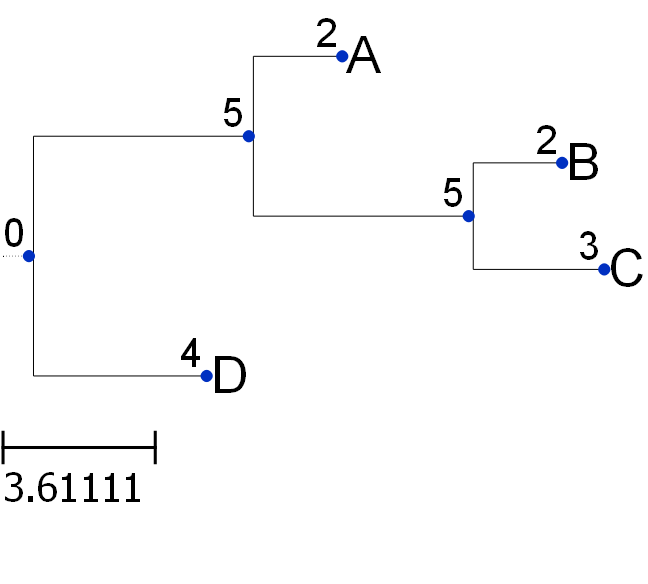

In [21]:
from ete3 import Tree, TreeStyle

newick_tree = '((A:2,(B:2,C:3):5):5,D:4);'
t = Tree(newick_tree)
ts = TreeStyle()
ts.show_branch_length = True
t.render('%%inline', w=183, units='mm', tree_style=ts)

**Exercice 6 :** Reécriver l'arbre suivant au format Newick puis afficher-le. Les nombres correspondent aux longueurs des branches :
![](tree.png)

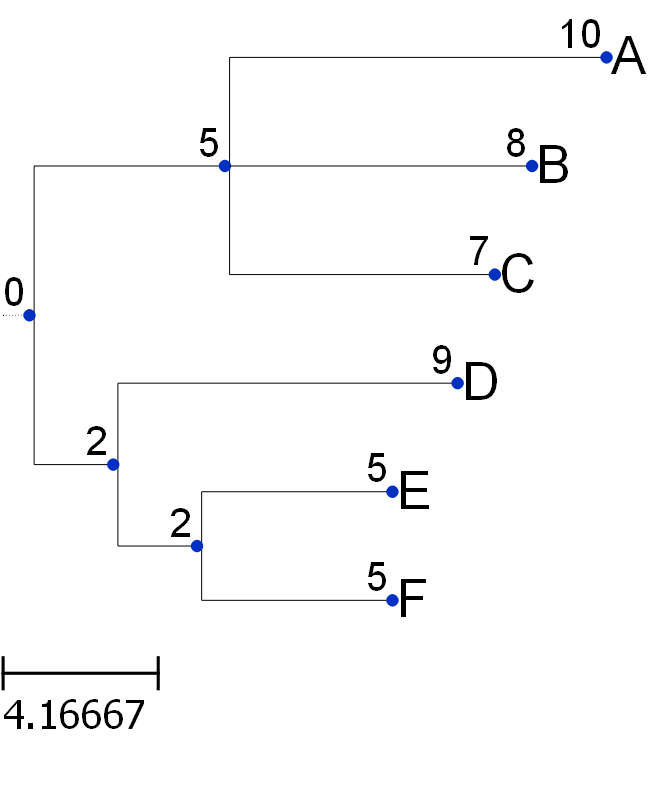

In [22]:
# À remplir
tree = '((A:10,B:8,C:7):5,(D:9,(E:5,F:5):2):2);'
t = Tree(tree)
ts = TreeStyle()
ts.show_branch_length = True
t.render('%%inline', w=183, units='mm', tree_style=ts)

**Exercice 7 :** Expliquer la relation de parenté entre $A$, $B$ et $C$ ? Qu'elles sont les hypothèses qui pourraient expliquer ce type d'embranchement dans un arbre ? Donner une réponse détaillée.

Réponse : 

les  UTOs A, B et C viennent d'un même ancêtre commun dont la longueur de la branche à la racine est de 5.
Ils sont apparentés de manière égale à leur ancêtre commun.
Mais, comme d_AB=18, d_AC=17,  A est plus similaire à C qu'à B et C est le plus similaire à leur ancêtre commun

L'apparition de nouvelles espèces filles à partir d'une espèce mère peut etre causée par une isolation géographique dûes à des événements métérologiques soudains par exemple, ce qui cause l'évolution séparées de ces espèces. Cette apparition de nouvelles espèces peut aussi etre dûes à une mutation soudaine au sein de la population, ce qui les isolent sexuellement et les forcent à évoluer séparement.

On peut supposer que ce type d'embranchement peut se produire si l’évolution a été multiple en un temps trop bref pour pouvoir distinguer lequel s'est produit en premier.

### UPGMA

L'algorithme UPGMA se base sur la matrice de distance entre les séquences. À chaque itération, les séquences avec la distance la plus faible sont regroupées puis une nouvelle matrice de distance est calculée avec le nouveau groupe. Cette étape est répétée jusqu'à n'avoir plus qu'un seul groupe. Par exemple, avec la matrice de distance entre les séquences $A$, $B$, $C$ et $D$ suivante :

|   &nbsp;   | A | B | C | D |
|   -   | - | - | - | - |
| **A** | &nbsp; | &nbsp; | &nbsp; | &nbsp; |
| **B** | 4 | &nbsp; | &nbsp; | &nbsp; |
| **C** | 8 | 8 | &nbsp; | &nbsp; |
| **D** | 2 | 4 | 8 | &nbsp; |

Les séquences $A$ et $D$ sont les plus proches ($distance(A,D)=2$). On les regroupe et on met à jour la matrice :

|   &nbsp;   | (A, D) | B | C |
|   -   | - | - | - |
| **(A, D)** | &nbsp; | &nbsp; | &nbsp; |
| **B** | 4 | &nbsp; | &nbsp; |
| **C** | 8 | 8 | &nbsp; | &nbsp; |

On regroupe maintenant $(A,D)$ et $B$ ($distance((A,D),B) = 4$) :

|   &nbsp;   | ((A, D), B) | C |
|   -   | - | - |
| **((A, D), B)** | &nbsp; | &nbsp; |
| **C** | 8 | &nbsp; |

Important : les nouvelles distances sont calculées en moyennant les distances entre les membres du nouveau groupe et des groupes non modifiés pondéré par le nombre d'UTOs dans chaque groupe. Avec $i$ et $j$ les deux membres du groupe nouvellement formé et k les groupes restant : $d_{ij,k} = \frac{n_id_{ik}}{n_i + n_j}+ \frac{n_jd_{jk}}{n_i + n_j}$. Par exemple avec la distance entre $((A, D), B)$ et $C$:

$distance(((A, D), B), C) = (distance((A, D), C)*2 + distance(B, C)) \mathbin{/} 3 = (8*2 + 8) \mathbin{/} 3 = 8 $.

L'arbre final écrit dans le format Newick est : $((A, D), B), C);$ 

Et avec les distances : $((A:1, D:1):1, B:2):2, C:4);$ 

**Exercice 8 :** Implémenter une version d'UPGMA qui calcule l'arbre au format Newick **avec les distances** puis appliquer votre algorithme aux données. 

UPGMA

In [23]:
nom2 = ['A', 'B', 'C', 'D','E']
M = np.reshape((0,4,8,2,4,0,8,4,8,8,0,8,2,4,8,0),(4,4))
M

array([[0, 4, 8, 2],
       [4, 0, 8, 4],
       [8, 8, 0, 8],
       [2, 4, 8, 0]])

In [24]:
#Initialisation des dictionnaires que l'on va utiliser
def init(M, uto):
    value2name = dict()
    name2size = dict()
    name2depth = dict()
    name2dist = dict()
    for i in range(len(uto)):
        name2size[uto[i]] = 1
        name2depth[uto[i]] = 0
        name2dist[uto[i]] = 0
    for i in range(np.shape(M)[0]):
        value2name[tuple(M[i])] = uto[i]
    return name2depth, name2size,value2name,name2dist

In [25]:
def minMatrice(m):
    MIN = 9999999 
    min_i = -1    
    min_j = -1    
    for i in range(np.shape(m)[0]):
        for j in range(np.shape(m)[1]):
            if m[i][j] < MIN and m[i][j] != 0:
                MIN = m[i][j]
                min_i = i
                min_j = j
    return min_i, min_j

In [26]:
def compteSize(s):
    res = 0
    for i in range(len(s)):
        if s[i] == '(':
            res+=1
    if res == 0:
        return 1 
    else:
        return res

In [27]:
#Renvoie la taille total de la branche
def joinBranche(a,b, taille,name2depth):
    return taille - name2depth[a]

In [28]:
def upgma(M,nom):
    res = np.copy(M)
    name2depth, name2size,value2name,name2dist = init(res,nom)
    print("begin")
    while(np.shape(M)[0] > 1):
        #Recuperation des indices du minimum
        idx, idy = minMatrice(M)
        print(name2dist)
        #le dict name2dist stocke la taille des branches
        name2dist[nom[idx]] = joinBranche(nom[idx], nom[idy],res[idx][idy]/2,name2depth)
        name2dist[nom[idy]] = joinBranche(nom[idy], nom[idx],res[idx][idy]/2,name2depth)
        n = max(name2dist[nom[idx]],name2dist[nom[idy]])
        
        name2depth[nom[idx]] += name2dist[nom[idx]]
        name2depth[nom[idy]] += name2dist[nom[idy]]
        n_depth = max(name2depth[nom[idx]],name2depth[nom[idy]])
        
        for i in range(np.shape(M)[0]):
            #La diagonale est a zero
            if i == idx: 
                res[idx][i] = 0
                res[i][idx] = 0
            elif i == idy: 
                res[idy][i] = 0
                res[i][idy] = 0
            else:
                #recalcul des distances
                ni = compteSize(nom[idx])
                nj = compteSize(nom[idy])
                res[idx][i] = ((M[idx][i] * ni) + (M[idy][i] * nj))/(ni+nj)
                res[i][idx] = ((M[i][idx] * ni) + (M[i][idy] * nj))/(ni+nj)
        
        

        #la taille du nouveau groupe créé est incrémenté
        name2size[nom[idx]]+=name2size[nom[idy]]
        new_size = name2size[nom[idx]] 
        
        #l'element a l'indice idy est supprimé de la matrice
        res = np.delete(res,idy,0)
        res = np.delete(res,idy,1)

        #Construction du nouveau groupe (pas utilisé je crois)
        new = "(" + nom[idx] + "," + nom[idy] + ")"
        #Construction du nouveau groupe avec les distances
        newN = "(" + nom[idx] + ':' + str(name2dist[nom[idx]]) +  "," + nom[idy] + ':' + str(name2dist[nom[idy]]) + ")"
        
        
        name2size.pop(nom[idx])#on enleve le nom de l'index idx
        nom[idx] = newN #On rajoute aux noms le nouveau groupe a la place de l'ancien nom d'indice idx
        name2size[newN] = new_size #ajout dans les noms
        name2dist[newN] = n 
        name2depth[newN] = n_depth
        
        
        name2size.pop(nom[idy])
        print(name2size)
        nom.pop(idy)
        value2name.clear()
        j= 0
        while(j < len(nom)):
            
            if(j != idy):
                value2name[tuple(res[j])] = nom[j] #on affecte les values aux noms
                j += 1
            else:
                j += 1 #on saute l'indice idy
        
        #mise a jour des parametres
        M = res
        new_size = 0
    return nom

In [29]:
#=========================test=============================
ex = np.reshape((0,4,8,2,4,0,8,4,8,8,0,8,2,4,8,0),(4,4))
exNom = ['A Anne DNA','B Bobby DNA','C Cath DNA','D Daniel DNA']
test = upgma(ex, exNom)

begin
{'A Anne DNA': 0, 'B Bobby DNA': 0, 'C Cath DNA': 0, 'D Daniel DNA': 0}
{'B Bobby DNA': 1, 'C Cath DNA': 1, '(A Anne DNA:1.0,D Daniel DNA:1.0)': 2}
{'A Anne DNA': 1.0, 'B Bobby DNA': 0, 'C Cath DNA': 0, 'D Daniel DNA': 1.0, '(A Anne DNA:1.0,D Daniel DNA:1.0)': 1.0}
{'C Cath DNA': 1, '((A Anne DNA:1.0,D Daniel DNA:1.0):1.0,B Bobby DNA:2.0)': 3}
{'A Anne DNA': 1.0, 'B Bobby DNA': 2.0, 'C Cath DNA': 0, 'D Daniel DNA': 1.0, '(A Anne DNA:1.0,D Daniel DNA:1.0)': 1.0, '((A Anne DNA:1.0,D Daniel DNA:1.0):1.0,B Bobby DNA:2.0)': 2.0}
{'(((A Anne DNA:1.0,D Daniel DNA:1.0):1.0,B Bobby DNA:2.0):2.0,C Cath DNA:4.0)': 4}


In [30]:
test

['(((A Anne DNA:1.0,D Daniel DNA:1.0):1.0,B Bobby DNA:2.0):2.0,C Cath DNA:4.0)']

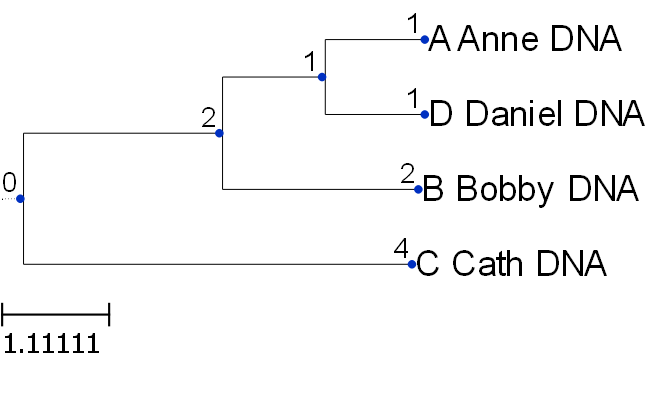

In [31]:
# À remplir
t = Tree(test[0] + ';')
ts = TreeStyle()
ts.show_branch_length = True
t.render('%%inline', w=183, units='mm', tree_style=ts)

In [32]:
#=========================un autre test=============================
ex3Nom = ['A','B','C','D','E','F']
ex3 =[[0.0, 2.0, 4.0, 6.0,6.0,8.0],
      [2.0, 0.0, 4.0, 6.0,6.0,8.0],
      [4.0, 4.0, 0.0, 6.0,6.0,8.0],
      [6.0, 6.0, 6.0, 0.0,4.0,8.0],
      [6.0, 6.0, 6.0, 4.0,0.0,8.0],
     [8.0, 8.0, 8.0, 8.0,8.0,0.0]]
test3 = upgma(ex3,ex3Nom)

begin
{'A': 0, 'B': 0, 'C': 0, 'D': 0, 'E': 0, 'F': 0}
{'C': 1, 'D': 1, 'E': 1, 'F': 1, '(A:1.0,B:1.0)': 2}
{'A': 1.0, 'B': 1.0, 'C': 0, 'D': 0, 'E': 0, 'F': 0, '(A:1.0,B:1.0)': 1.0}
{'D': 1, 'E': 1, 'F': 1, '((A:1.0,B:1.0):1.0,C:2.0)': 3}
{'A': 1.0, 'B': 1.0, 'C': 2.0, 'D': 0, 'E': 0, 'F': 0, '(A:1.0,B:1.0)': 1.0, '((A:1.0,B:1.0):1.0,C:2.0)': 2.0}
{'F': 1, '((A:1.0,B:1.0):1.0,C:2.0)': 3, '(D:2.0,E:2.0)': 2}
{'A': 1.0, 'B': 1.0, 'C': 2.0, 'D': 2.0, 'E': 2.0, 'F': 0, '(A:1.0,B:1.0)': 1.0, '((A:1.0,B:1.0):1.0,C:2.0)': 2.0, '(D:2.0,E:2.0)': 2.0}
{'F': 1, '(((A:1.0,B:1.0):1.0,C:2.0):1.0,(D:2.0,E:2.0):1.0)': 5}
{'A': 1.0, 'B': 1.0, 'C': 2.0, 'D': 2.0, 'E': 2.0, 'F': 0, '(A:1.0,B:1.0)': 1.0, '((A:1.0,B:1.0):1.0,C:2.0)': 1.0, '(D:2.0,E:2.0)': 1.0, '(((A:1.0,B:1.0):1.0,C:2.0):1.0,(D:2.0,E:2.0):1.0)': 1.0}
{'((((A:1.0,B:1.0):1.0,C:2.0):1.0,(D:2.0,E:2.0):1.0):1.0,F:4.0)': 6}


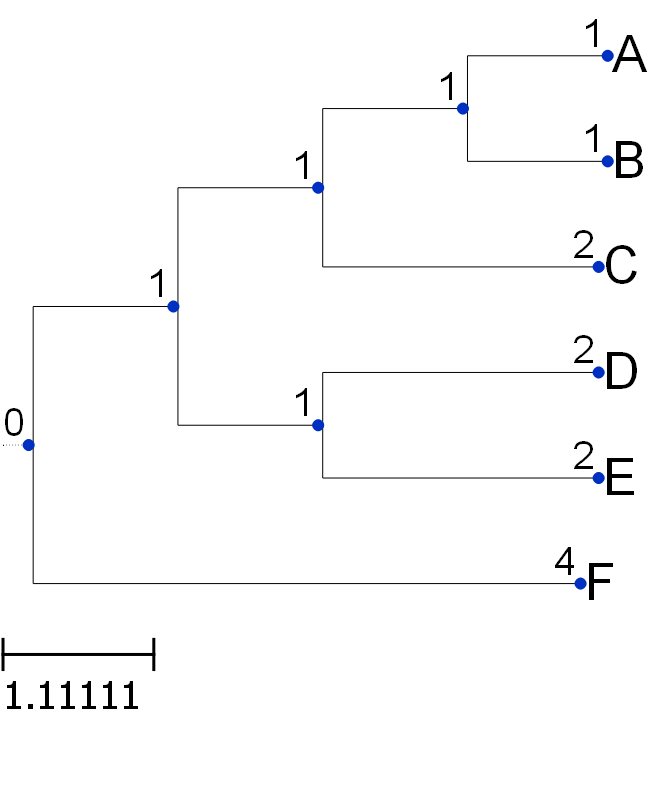

In [33]:
t = Tree(test3[0] + ';')
ts = TreeStyle()
ts.show_branch_length = True
t.render('%%inline', w=183, units='mm', tree_style=ts)

In [34]:
uto = []
for key, value in data.items():
    uto.append(key)
for i in range(len(uto)):
    uto[i] = uto[i].replace('(', '[')
    uto[i] = uto[i].replace(')', ']')

In [35]:
uto #noms que l'on va utiliser

['Sabertooth DNA [Smilodon]',
 'Homotherium DNA',
 'American Cat DNA [Miracinonyx]',
 'Spotted Hyena DNA',
 'Striped Hyena DNA',
 'Chinese Desert cat DNA',
 'African wild cat DNA',
 'Felis Cat A DNA',
 'Wild Cat DNA',
 'Cheetah DNA',
 'Puma DNA',
 'Tiger DNA',
 'Lion DNA',
 'Leopard DNA',
 'Dog DNA',
 'Wolf DNA',
 'Black Bear DNA',
 'Brown Bear DNA',
 'Cave Bear DNA']

In [36]:
matrice = distance(data) #calcul de la matrice de distance des données

In [37]:
#=========================execution sur les données=============================
projet = upgma(matrice,uto) 

begin
{'Sabertooth DNA [Smilodon]': 0, 'Homotherium DNA': 0, 'American Cat DNA [Miracinonyx]': 0, 'Spotted Hyena DNA': 0, 'Striped Hyena DNA': 0, 'Chinese Desert cat DNA': 0, 'African wild cat DNA': 0, 'Felis Cat A DNA': 0, 'Wild Cat DNA': 0, 'Cheetah DNA': 0, 'Puma DNA': 0, 'Tiger DNA': 0, 'Lion DNA': 0, 'Leopard DNA': 0, 'Dog DNA': 0, 'Wolf DNA': 0, 'Black Bear DNA': 0, 'Brown Bear DNA': 0, 'Cave Bear DNA': 0}
{'Sabertooth DNA [Smilodon]': 1, 'Homotherium DNA': 1, 'American Cat DNA [Miracinonyx]': 1, 'Spotted Hyena DNA': 1, 'Striped Hyena DNA': 1, 'Chinese Desert cat DNA': 1, 'Felis Cat A DNA': 1, 'Cheetah DNA': 1, 'Puma DNA': 1, 'Tiger DNA': 1, 'Lion DNA': 1, 'Leopard DNA': 1, 'Dog DNA': 1, 'Wolf DNA': 1, 'Black Bear DNA': 1, 'Brown Bear DNA': 1, 'Cave Bear DNA': 1, '(African wild cat DNA:0.0053192381219836545,Wild Cat DNA:0.0053192381219836545)': 2}
{'Sabertooth DNA [Smilodon]': 0, 'Homotherium DNA': 0, 'American Cat DNA [Miracinonyx]': 0, 'Spotted Hyena DNA': 0, 'Striped Hyena DNA

In [38]:
arbre = projet[0]+";" #arbre final en format newick

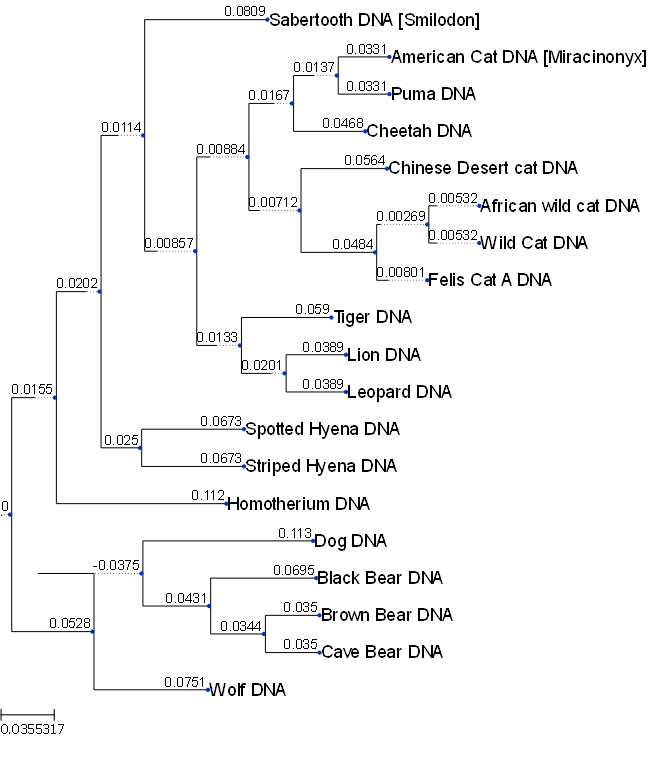

In [39]:
# À remplir
t = Tree(arbre)
ts = TreeStyle()
ts.show_branch_length = True
t.render('%%inline', w=183, units='mm', tree_style=ts)

**Exercice 9 :** Quelles sont les hypothèses faites par UPGMA ? Semblent-elles respectées dans le cas présent ?

Réponse : UPGMA fait l'hypothèse que toutes les séquences évoluent à la même vitesse, les distances évolutives entre chaque feuille et la racine sont égales, la racine est placée au point de l’arbre équidistant de toutes les feuilles.

Ces hypothèse ne semblent pas être respectées comme les distances évolutives entre chaque feuille et la racine ne sont pas égale, les
séquences ne semblent pas évoluer à la même vitesse

----
## Enracinement de l'arbre

Après avoir utilisé UPGMA pour réaliser votre arbre, l'enracinement s'est normalement fait au poids moyen. 

**Exercice 10 :** Quelle autre méthode est-il possible d'utiliser pour enraciner un arbre ? Pouvez-vous l'utilisez ici ? Si oui, afficher le nouvel arbre.

Réponse : 

Une autre méthode est l'enracinement avec groupe exterieur. Pour cela, il faut un groupe de séquences homologues aux séquences analysées mais dont on sait a priori
qu’elles sont extérieures aux séquences analysées . 

Un nouveau noeud est crée reliant les séquences étudiées au groupe extérieur. On peut définir ce groupe exterieur comme étant composé de Wolf DNA, Dog DNA et des différents Bear DNA

----
## Neighbor-joining

Le neighbor-joining est un autre algorithme permettant de calculer un arbre phylogénique à partir d'une matrice de distance. Il a l'avantage de faire moins d'hypothèse qu'UPGMA sur les données (elles ne sont plus forcément ultramétrique) et il donne donc de meilleurs arbres dans presque tout les cas. Vous trouverez un example d'application de cet algorithme [ici](http://www.evolution-textbook.org/content/free/tables/Ch_27/T11_EVOW_Ch27.pdf).

**Exercice 11 :** Implémenter l'algorithme du neighbor-joining, appliquer-le aux données puis enraciner l'arbre.

In [40]:
#Step 1
def calculS(M,nom):
    res = dict()
    for i in range(len(nom)):
        somme = 0
        for j in range(np.shape(M)[0]):
            somme += M[i][j]
        res[nom[i]] = somme/(len(nom)-2)
    return res

#Step 2
def smallestM(M,nom, S):
    res = np.zeros((len(S),len(S)))
    for i in range(len(S)):
        for j in range(len(S)):
            if j == i:
                res[i][j]= 0
            else:
                res[i][j]= M[i][j] - S[nom[i]] - S[nom[j]]
    return res

#renvoie les indices du min de la matrice
def paireMin(M):
    min = M[0][0]
    idx = -1
    idy = -1 
    for i in range(np.shape(M)[0]):
        for j in range(np.shape(M)[1]):
            if M[i][j] < min:
                min = M[i][j]
                idx = i
                idy = j
    return idx,idy

#Step 3
def joinPair(M,nom,S,idx,idy):
    S1= (M[idx][idy]/2) + (S[nom[idx]] - S[nom[idy]])/2
    S2= (M[idx][idy]/2) + (S[nom[idy]] - S[nom[idx]])/2
    res = '(' + nom[idx] + ':' + str(S1) + ',' + nom[idy] + ':' + str(S2) + ')'
    return res

#Step 3 pour le dernier cycle
def joinLast(M,nom,S,idx,idy):
    S1= (M[idx][idy])/2
    S2= (M[idx][idy])/2
    res = '(' + nom[idx] + ':' + str(S1) + ',' + nom[idy] + ':' + str(S2) + ')'
    return res

#mise a jour de la matrice avec le nouveau groupe
def majMatrice(M,nom,idx,idy):
    res = np.copy(M)
    for i in range(np.shape(res)[0]):
        if i == idx: 
            res[idx][i] = 0
            res[i][idx] = 0
        elif i == idy: 
            res[idy][i] = 0
            res[i][idy] = 0
        else:
            res[idx][i] = (M[idx][i] + M[idy][i] - M[idx][idy])/2
            res[i][idx] = (M[i][idx] + M[i][idy] - M[idx][idy])/2
    
    res = np.delete(res,idy,0)
    res = np.delete(res,idy,1)
    nom.pop(idy)
    return res

#fonction principale
def neighbor(M,nom):
    res = np.copy(M)
    idx = -1
    idy = -1
    while(np.shape(res)[0]-2>0):
        S = calculS(res,nom)
        small = smallestM(res,nom,S)
        idx,idy = paireMin(small)
        nom[idx] = joinPair(res,nom,S,idx,idy)
        res = majMatrice(res,nom,idx,idy)
        print(S)
    
    nom[0] = joinLast(res,nom,S,0,1)
    
    res = majMatrice(res,nom,0,1)
    print(S)
    return nom

In [41]:
#=========================test=============================
D = [[0,5,4,7,6,8],
    [5,0,7,10,9,11],
    [4,7,0,7,6,8],
    [7,10,7,0,5,9],
    [6,9,6,5,0,8],
    [8,11,8,9,8,0]]
nom = ['A','B','C','D','E','F']

exemple = neighbor(D,nom)[0] + ";"

{'A': 7.5, 'B': 10.5, 'C': 8.0, 'D': 9.5, 'E': 8.5, 'F': 11.0}
{'(A:1.0,B:4.0)': 7.0, 'C': 8.0, 'D': 9.0, 'E': 8.0, 'F': 10.666666666666666}
{'((A:1.0,B:4.0):1.0,C:2.0)': 7.5, 'D': 9.5, 'E': 8.5, 'F': 11.5}
{'(((A:1.0,B:4.0):1.0,C:2.0):1.0,F:5.0)': 7.0, 'D': 9.0, 'E': 8.0}
{'(((A:1.0,B:4.0):1.0,C:2.0):1.0,F:5.0)': 7.0, 'D': 9.0, 'E': 8.0}


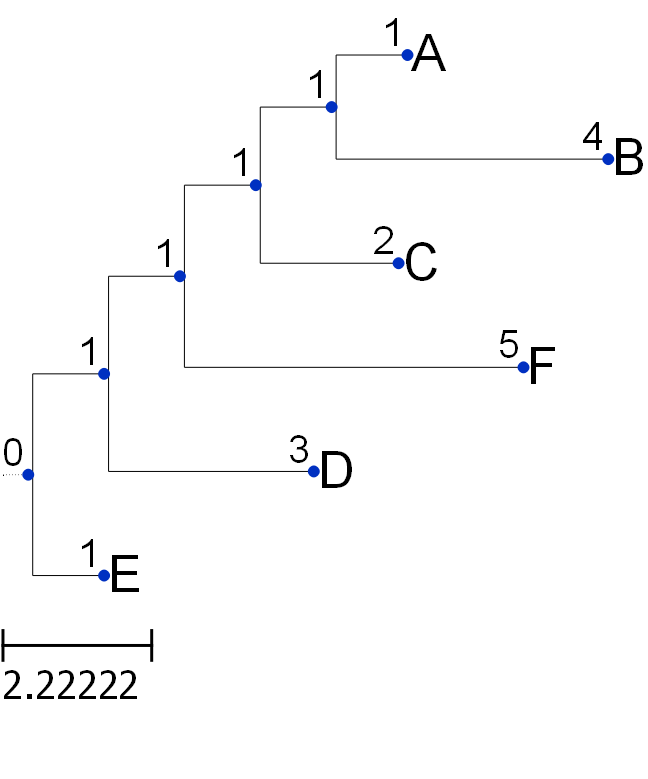

In [42]:
t = Tree(exemple)
ts = TreeStyle()
ts.show_branch_length = True
t.render('%%inline', w=183, units='mm', tree_style=ts)

In [43]:
uto = []
for key, value in data.items():
    uto.append(key)
for i in range(len(uto)):
    uto[i] = uto[i].replace('(', '[')
    uto[i] = uto[i].replace(')', ']')

In [44]:
uto

['Sabertooth DNA [Smilodon]',
 'Homotherium DNA',
 'American Cat DNA [Miracinonyx]',
 'Spotted Hyena DNA',
 'Striped Hyena DNA',
 'Chinese Desert cat DNA',
 'African wild cat DNA',
 'Felis Cat A DNA',
 'Wild Cat DNA',
 'Cheetah DNA',
 'Puma DNA',
 'Tiger DNA',
 'Lion DNA',
 'Leopard DNA',
 'Dog DNA',
 'Wolf DNA',
 'Black Bear DNA',
 'Brown Bear DNA',
 'Cave Bear DNA']

In [45]:
neighbor = neighbor(matrice,uto)[0] + ";"

{'Sabertooth DNA [Smilodon]': 0.20199078232274262, 'Homotherium DNA': 0.2568527474596095, 'American Cat DNA [Miracinonyx]': 0.1822312863181933, 'Spotted Hyena DNA': 0.21328646763489054, 'Striped Hyena DNA': 0.22213387851027555, 'Chinese Desert cat DNA': 0.181182869802826, 'African wild cat DNA': 0.1785987075048627, 'Felis Cat A DNA': 0.1809349357539284, 'Wild Cat DNA': 0.18025707362424054, 'Cheetah DNA': 0.18761196325646057, 'Puma DNA': 0.19317208585912282, 'Tiger DNA': 0.18735112003092505, 'Lion DNA': 0.19578853366019802, 'Leopard DNA': 0.19772936944154892, 'Dog DNA': 0.24861370716144748, 'Wolf DNA': 0.24861370716144748, 'Black Bear DNA': 0.24776298742506722, 'Brown Bear DNA': 0.26951153963013935, 'Cave Bear DNA': 0.24845454946359288}
{'Sabertooth DNA [Smilodon]': 0.19879903536495394, 'Homotherium DNA': 0.25487986808417024, 'American Cat DNA [Miracinonyx]': 0.17749516379615066, 'Spotted Hyena DNA': 0.2108007010091111, 'Striped Hyena DNA': 0.21958020506030046, 'Chinese Desert cat DNA':

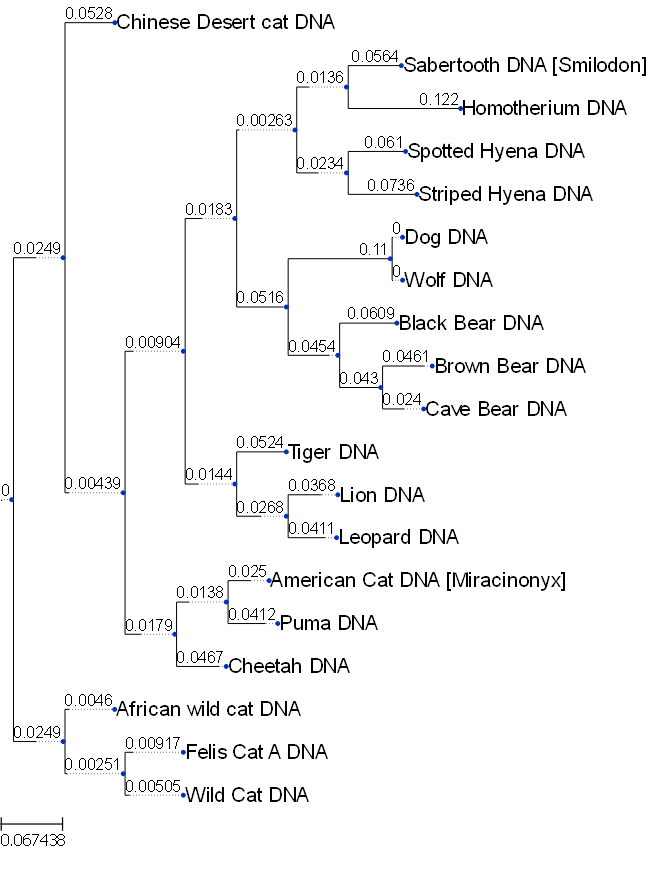

In [46]:
t = Tree(neighbor)
ts = TreeStyle()
ts.show_branch_length = True
t.render('%%inline', w=183, units='mm', tree_style=ts)

----
## Bootstrap

Le bootstrap est une méthode permettant de calculer la robustesse des branches d'un arbre. Il sagit de recréer un jeu de données artificiel en tirant n positions dans l'alignement des séquences avec remise, n étant la longueur de l'alignement. On recréer un arbre à partir de ces nouvelles données puis on le compare avec l'arbre obtenu avec les données réelles. Si une branche de l'arbre réelle est présente dans l'arbre artificiel, son bootstrap augmente de 1. On répètera la procédure 100 fois afin d'avoir un score sur 100 pour chaque branche.

**Exercice 12 :** Calculer le bootstrap des branches des arbres obtenus avec UPGMA et neighbor-joining.

In [47]:
# À remplir

----
## Conclusion

**Exercice 12 :** Quelles sont vos conclusions par rapport à l'arbre phylogénique de *smilodon*, *homotherium* et _M. trumani_ ? Comparer les deux méthodes. Comment expliquer les caractéristiques morphologiques similaires entre ces trois espèces ? Une réponse détaillée est attendue.

Réponse :

Les trois espèces présentent plusieurs ancêtres communs, ce qui peut expliquer certaines de leur caractéristiques morphologiques communes.

Dans l'arbre phylogénique créé par neighbor joining, le smilodon est plus apparenté à l'homotherium qu'au M.trumani.
Dans les deux arbres, le M. trumani est plus similaire au smilodon qu'à l'homotherium.